In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_adata(adata_to_plot, cluster_key, plot_type="umap", keyword=None, save=None, Title = "UMAP or Spatial embedding — clusters"):
    """
    Plot AnnData embeddings (UMAP or spatial) with optional HTML export.

    Parameters:
    - adata_to_plot: AnnData object with .obsm and .obs fields.
    - cluster_key: key in adata.obs to color by.
    - plot_type: "umap" or "spatial".
    - keyword: if provided, highlight clusters containing this substring; others grouped as "Other".
    - save: if None, do not save; if str, full path/filename to save as HTML (no extension needed).
    """

    # Prepare DataFrame for plotting
    if plot_type == "spatial":
        coords = adata_to_plot.obsm['spatial'].copy()
        df = pd.DataFrame(coords, columns=['x', 'y'], index=adata_to_plot.obs_names)
    else:  # UMAP
        df = pd.DataFrame(
            adata_to_plot.obsm['X_umap'],
            columns=['UMAP1', 'UMAP2'],
            index=adata_to_plot.obs_names
        )

    # Original cluster labels as strings
    df[cluster_key] = adata_to_plot.obs[cluster_key].astype(str)

    # If a keyword is provided, label matching clusters, others as "Other"
    if keyword:
        df['plot_label'] = df[cluster_key].apply(lambda x: x if keyword in x else 'Other')
        color_key = 'plot_label'
        legend_title = f"Highlighted: {keyword}"
    else:
        color_key = cluster_key
        legend_title = cluster_key

    # Get a discrete color map
    tab20 = [mpl.colors.rgb2hex(c) for c in plt.get_cmap('tab20').colors]

    # Choose appropriate scatter fields
    if plot_type == "spatial":
        fig = px.scatter(
            df,
            x='x',
            y='y',
            color=color_key,
            title=Title,
            hover_name=df.index,
            width=1600,
            height=700
        )
        fig.update_traces(marker=dict(size=2, opacity=0.8))
        fig.update_yaxes(autorange='reversed')
    else:  # UMAP
        fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color=color_key,
            title=Title,
            color_discrete_sequence=tab20,
            hover_name=df.index,
            width=1400,
            height=1200
        )
        fig.update_traces(marker=dict(size=3, opacity=0.8))

    # Adjust layout
    fig.update_layout(
        legend_title_text=legend_title,
        legend=dict(
            itemsizing='constant',
            traceorder='normal',
            bgcolor='rgba(255,255,255,0.5)',
            x=1.02,
            y=1
        ),
        margin=dict(l=20, r=200, t=50, b=20)
    )

    # Show plot
    fig.show()

    # Save if a path is given
    if isinstance(save, str):
        fig.write_html(f"{save}.html")

## Import adata file

In [31]:
import spatialdata
import scanpy as sc


Tissue = "Region2"
#MajorType = "Mesenchymal_SubTypes"

#adata = sc.read_h5ad(f'/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/Results/{Tissue}/{Tissue}.{MajorType}.AnnDC.h5ad')
adata = sc.read_h5ad(f'/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/Results/{Tissue}/{Tissue}.AnnDc.All.h5ad')
adata

AnnData object with n_obs × n_vars = 266502 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'cell_type', 'leiden', 'major_cell_type_xenium_panel', 'assigned_celltype', 'MajorTypes'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial'

## Read TILEs inside the Region (Pre-Filtered in previous script) !

In [4]:
import pandas as pd

TILEs = pd.read_csv("/Users/ugursahin/ProstateCancerEvo_SpatialAnalysis/scripts/genomics_integration/Barcode_TileClone_Pair.csv")
TILEs

,cell_id,Tile,Clone
0,aadpfmbk-1,plate4_7B_,255_255_255
1,aadpinjf-1,plate4_7B_,255_255_255
2,aaebkgoh-1,plate4_7B_,255_255_255
3,aaebmicj-1,plate4_7B_,255_255_255
4,aaecaajp-1,plate4_7B_,255_255_255
...,...,...,...
43806,ogigmfio-1,plate4_12H-scraped_,255_255_0
43807,ogikeffm-1,plate4_12H-scraped_,255_255_0
43808,ogjlkhgi-1,plate4_12H-scraped_,255_255_0
43809,ogjmemjc-1,plate4_12H-scraped_,255_255_0


## You need to save index and order so add "Clone" and "Tile" info in last column in for loop !

In [ ]:
adata_obs = adata.obs.copy()

# 1) Ensure “cell_id” is a column—and unique—in adata_obs
adata_obs["cell_id"] = adata_obs["cell_id"].astype(str)

# 2) Create the new columns with a default (e.g. NaN or a placeholder)
adata_obs["Tile"]  = pd.NA
adata_obs["Clone"] = pd.NA

# 3) Iterate over TILEs, and for each row: if that cell_id is in adata_obs, assign
c = 0
for _, row in TILEs.iterrows():
    cid = str(row["cell_id"])
    c += 1
    print(c)
    if cid in adata_obs["cell_id"].values:
        # Find the index(es) in adata_obs where cell_id == cid
        mask = adata_obs["cell_id"] == cid
        adata_obs.loc[mask, "Tile"]  = row["Tile"]
        adata_obs.loc[mask, "Clone"] = row["Clone"]
    # else: simply skip that row (do nothing)

adata.obs = adata_obs

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Define FGSEA function chosen - Subtype vs Remains

In [20]:
import scanpy as sc
import gseapy as gp

def go_fgsea(adata, ref, comp, cluster_key="leiden" , gene_set="GO_Biological_Process_2025", show_plot = False):
    Reference, Delta = adata[adata.obs[cluster_key] == ref], \
                       adata[adata.obs[cluster_key] == comp]
    
    adata_concat = sc.concat(
        [Reference, Delta],
        axis=0,
        join="inner",                # keep only shared variables
        label="subset",              # name of the new obs‐column
        keys=[ref, comp],
        merge="same"                 # assume var‐ and obsm‐entries are identical
    )

    if show_plot:
         sc.pl.umap(
         adata_concat,
         color="subset",
         palette=["red","blue"],
         size=20,
         title=f"UMAP Comparisons of {ref} as reference vs {comp} as comparison",
         alpha = 0.4)

    # 1) Run differential expression: PartialTumor vs TumorEnriched
    sc.tl.rank_genes_groups(
    adata_concat,
    groupby='subset',
    groups=[comp],
    reference=ref,
    method='t-test'          # or 't-test', 'logreg', etc.
    )

    # 2) Extract a pre-ranked list of genes (log₂-fold-changes)
    de_df = sc.get.rank_genes_groups_df(
    adata_concat,
    group=comp,
    key='rank_genes_groups'
    )
    rnk = de_df.set_index('names')['logfoldchanges']

    pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=gene_set,     # or path to your GMT file
    processes=4,
    permutation_num=10000,
    outdir=None)

    terms = pre_res.res2d.Term
    axs = pre_res.plot(terms=[terms[0], terms[1], terms[2]],
    #legend_kws={'loc': (1.2, 0)}, # set the legend loc
    show_ranking=True, # whether to show the second yaxis
    figsize=(6,12)
)

    return pre_res.res2d[pre_res.res2d["NOM p-val"] < 0.05]

In [34]:
adata_just_TILE = adata_obs[adata_obs["Clone"].notna()]
adata_just_TILE

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,cell_type,leiden,major_cell_type_xenium_panel,assigned_celltype,MajorTypes,Tile,Clone
192,aacieppf-1,33,0,0,0,0,0,33.0,40.324533,22.668438,...,63.636364,100.000000,100.000000,pten,3,hematopoieticcell,CD4 T Cell,0,plate4_7C_,255_255_0
220,aacmhpan-1,117,0,0,0,0,0,117.0,47.188283,26.371251,...,30.769231,56.410256,100.000000,CD4,2,hematopoieticcell,CD8 and CD4 T Cell,0,plate4_7C_,255_255_0
221,aacmlkpn-1,150,0,0,0,0,0,150.0,50.484689,25.558438,...,27.333333,47.333333,100.000000,FOXp3,9,hematopoieticcell,CD8 T Cell,0,plate4_7C_,255_255_0
222,aacmnegj-1,164,0,0,0,0,0,164.0,51.116877,24.248907,...,21.341463,39.634146,100.000000,pten,2,hematopoieticcell,CD8 and CD4 T Cell,0,plate4_7C_,255_255_0
223,aacmnhgc-1,113,0,0,0,0,1,113.0,43.530627,25.919688,...,27.433628,53.982301,100.000000,CD20,7,hematopoieticcell,Bcell,0,plate4_7C_,255_255_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299297,oigaccnb-1,4,0,0,0,0,0,4.0,19.010782,19.010782,...,100.000000,100.000000,100.000000,aSMA,0,epithelialcellofprostate,tumor_cell_markers,2,plate4_4H_,102_0_102
299360,oigkengb-1,8,0,0,0,0,0,8.0,15.488594,15.488594,...,100.000000,100.000000,100.000000,TFAM,13,epithelialcellofprostate,basal_epithelial_cell_of_prostatic_duct,2,plate4_2E_,102_0_102
299538,oijajpjh-1,244,0,0,0,0,1,244.0,90.944691,84.487347,...,25.000000,37.295082,78.278689,CD68,1,epithelialcellofprostate,tumor_cell_markers,2,plate4_9E_,102_0_102
299693,oildjlka-1,9,0,0,0,0,0,9.0,17.249688,17.249688,...,100.000000,100.000000,100.000000,PDL-1,0,epithelialcellofprostate,tumor_cell_markers,2,plate4_3D_,128_0_128


In [35]:
from collections import Counter 

adata_just_TILE = adata_obs[adata_obs["Clone"].notna()]
adata_tumor_inTILEs = adata_just_TILE[adata_just_TILE["assigned_celltype"] == "tumor_cell_markers"]

mask_tumor_inTILEs = adata_tumor_inTILEs.cell_id.astype(str).to_list()
adata.obs["Clone"] = adata.obs["Clone"].astype("category")
Counter(adata_tumor_inTILEs["Clone"].to_list())

Counter({'102_0_102': 11024,
         '0_255_0': 1907,
         '255_255_255': 1313,
         '255_255_0': 771,
         '128_0_128': 462,
         '0_0_0': 25})

## Introduce new adata.obs which is "Clone" and "Tile" informations are added !

In [36]:
adata_tumor_inTiles =  adata[adata.obs["cell_id"].isin(mask_tumor_inTILEs)].copy()
adata_tumor_inTiles.obs["assigned_celltype"]

232       tumor_cell_markers
329       tumor_cell_markers
330       tumor_cell_markers
344       tumor_cell_markers
345       tumor_cell_markers
                 ...        
298711    tumor_cell_markers
299297    tumor_cell_markers
299538    tumor_cell_markers
299693    tumor_cell_markers
299727    tumor_cell_markers
Name: assigned_celltype, Length: 15502, dtype: category
Categories (1, object): ['tumor_cell_markers']

/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:10:43,541 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:10:43,553 [WARNING] Duplicated values found in preranked stats: 0.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Allograft Rejection,-0.417499,-1.729848,0.0,0.039183,0.0319,30/95,11.25%,CCR5;CCL7;INHBA;IL2RA;CCR2;IL6;TLR3;CD3D;EGFR;...
1,prerank,Myc Targets V1,0.524975,1.7124,0.000236,0.043916,0.0447,38/76,25.17%,CCT7;VDAC1;SRSF2;TARDBP;MCM5;KPNA2;NOLC1;EIF4A...
6,prerank,Epithelial Mesenchymal Transition,-0.424437,-1.570485,0.005411,0.054557,0.1244,13/51,10.22%,WNT5A;MFAP5;INHBA;ITGB5;CXCL1;COL5A2;IL6;CDH2;...
4,prerank,KRAS Signaling Up,-0.413215,-1.585783,0.006037,0.072465,0.1106,24/59,19.07%,ETV5;HSD11B1;INHBA;TLR8;HDAC9;TSPAN7;CD37;TSPA...
5,prerank,Adipogenesis,0.50545,1.576251,0.006284,0.070469,0.2523,20/56,17.19%,BCL6;ME1;LPL;PTCD3;GBE1;PGM1;REEP6;ATL2;IMMT;S...
3,prerank,Fatty Acid Metabolism,0.555585,1.610938,0.006473,0.061351,0.1738,20/36,26.48%,ME1;CBR1;ALAD;SLC22A5;UGDH;CRYZ;REEP6;HADHB;PP...
2,prerank,Interferon Alpha Response,0.601141,1.624995,0.008553,0.077184,0.1479,10/25,9.70%,PNPT1;LPAR6;CSF1;IFI35;MOV10;HERC6;TAP1;IFIH1;...
7,prerank,mTORC1 Signaling,0.46333,1.5086,0.008581,0.119498,0.4572,29/75,23.54%,ME1;HSPA4;SLC9A3R1;SQSTM1;TOMM40;HSPA9;GBE1;PG...
13,prerank,Inflammatory Response,-0.342876,-1.38563,0.019066,0.150437,0.3881,23/84,16.07%,GCH1;RASGRP1;CXCR6;CCL7;INHBA;IL6;TLR3;CLEC5A;...
8,prerank,Oxidative Phosphorylation,0.511445,1.504377,0.020828,0.104325,0.4719,25/39,31.98%,VDAC1;MFN2;HADHA;LRPPRC;HSPA9;ATP5F1A;IMMT;ATP...


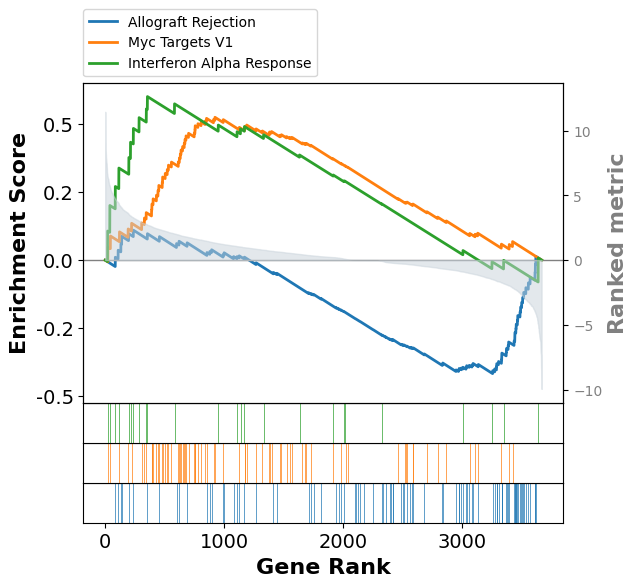

In [37]:
pre_res = go_fgsea(adata, "0_255_0", "255_255_255", cluster_key="Clone" ,gene_set="MSigDB_Hallmark_2020" , show_plot=False)
pre_res.sort_values("NOM p-val").head(10)

## Tumor Cell Counts of Leiden by TILEs 

In [26]:
import pandas as pd
import plotly.express as px

# 1. Extract the relevant columns from your AnnData
obs = adata_tumor_inTiles.obs[['Clone', 'leiden']].copy()

# 2. Filter to only the six Clone groups of interest
clone_list = ['102_0_102', '255_255_0', '255_255_255', '0_255_0', '128_0_128', '0_0_0']
obs = obs[obs['Clone'].isin(clone_list)]

# 3. Compute raw counts of each leiden within each Clone
counts = (
    obs
    .groupby(['Clone', 'leiden'])
    .size()
    .reset_index(name='count')
)

# 4. Create a stacked bar chart in Plotly
fig = px.bar(
    counts,
    x='Clone',
    y='count',
    color='leiden',
    title='Leiden‐TILE Distribution (Raw TUMOR Cell Counts) within Each Clone',
    labels={
        'count': 'Number of Cells',
        'Clone': 'Clone Name',
        'leiden': 'Leiden Group'
    },
    text='count'
)

fig.update_traces(
    texttemplate='%{text}',  # show raw counts
    textposition='inside'
)
fig.update_layout(
    barmode='stack',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2242135879.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Clone', 'leiden'])


## Leiden–TILE Distribution (Raw Tumor Cell Counts) within Each Clone

In [27]:
import pandas as pd
import plotly.express as px

# 1. Extract the relevant columns from your AnnData
obs = adata_tumor_inTiles.obs[['Clone', 'leiden']].copy()

# 2. Filter to only the Leiden groups of interest
leiden_list = ["0","1","2","3","6","7","9","10","12"]
obs = obs[obs['leiden'].isin(leiden_list)]

# 3. Compute raw counts of each Leiden within each Clone
counts = (
    obs
    .groupby(['leiden', 'Clone'])
    .size()
    .reset_index(name='count')
)

# 4. Define the color map for each Clone (right‐hand side is the Clone code)
#    Left‐hand side is the CSS color name you want to use
color_discrete_map = {
    "0_255_0":   "DarkOrange",   # DarkOrange → clone “0_255_0”
    "255_255_0": "Yellow",   # DarkYellow → clone “255_255_0”
    "255_255_255": "LightBlue",  # LightBlue  → clone “255_255_255”
    "102_0_102": "Brown",        # Brown      → clone “102_0_102”
    "128_0_128": "Purple",       # Purple     → clone “128_0_128”
    "0_255_255": "Red",          # Red        → clone “0_255_255”
    "0_0_0":     "DarkBlue",     # DarkBlue   → clone “0_0_0”
}

# 5. Create a stacked bar chart in Plotly, passing in our color map
fig = px.bar(
    counts,
    x='leiden',
    y='count',
    color='Clone',
    title='Leiden–TILE Distribution (Raw Tumor Cell Counts) within Each Clone',
    labels={
        'count': 'Number of Cells',
        'Clone': 'Clone Name',
        'leiden': 'Leiden Group'
    },
    text='count',
    color_discrete_map=color_discrete_map
)

# 6. Show raw counts inside each segment
fig.update_traces(
    texttemplate='%{text}',
    textposition='inside'
)
fig.update_layout(
    barmode='stack',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2274055158.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [28]:
Counter(adata_tumor_inTiles.obs["leiden"].to_list())

Counter({'0': 3983,
         '1': 3605,
         '2': 2278,
         '9': 1548,
         '6': 1444,
         '3': 997,
         '7': 828,
         '10': 516,
         '12': 303})

## Cross Check of Loc of Tiles and Tile Tagged Cells

In [29]:
plot_adata(adata_tumor_inTiles, "Clone", plot_type="spatial", keyword=None, save=None, Title="TILEs on SpatialMap")

## CellType Content of Tiles 

In [30]:
import pandas as pd
import plotly.express as px

# 1. Extract the relevant columns from your AnnData
obs = adata.obs[['Clone', 'assigned_celltype']].copy()

# 2. Filter to only the six Clone groups of interest
clone_list = ['102_0_102', '255_255_0', '255_255_255', '0_255_0', '128_0_128', '0_0_0']
obs = obs[obs['Clone'].isin(clone_list)]

# 3. Compute raw counts of each leiden within each Clone
counts = (
    obs
    .groupby(['Clone', 'assigned_celltype'])
    .size()
    .reset_index(name='count')
)

# 4. Create a stacked bar chart in Plotly
fig = px.bar(
    counts,
    x='Clone',
    y='count',
    color='assigned_celltype',
    title='Leiden‐TILE Distribution (Raw Cell Counts) within Each Clone',
    labels={
        'count': 'Number of Cells',
        'Clone': 'Clone Name',
        'assigned_celltype': 'Leiden Group'
    },
    text='count'
)

fig.update_traces(
    texttemplate='%{text}',  # show raw counts
    textposition='inside'
)
fig.update_layout(
    barmode='stack',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/953065347.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Paired Comparison of Tiles !

255_255_255 255_255_0


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:14,880 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:14,896 [WARNING] Duplicated values found in preranked stats: 0.53% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:17,539 [WARNING] Input gene rankings contains NA values(gene name and ranking value), dr

255_255_255 128_0_128


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:19,782 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:19,794 [WARNING] Duplicated values found in preranked stats: 3.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


255_255_255 0_0_0
255_255_255 102_0_102


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:24,065 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:24,075 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:27,988 [WARNING] Input gene rankings contains NA values(gene name and ranking value), dr

255_255_255 0_255_0


2025-06-05 12:35:27,998 [WARNING] Duplicated values found in preranked stats: 0.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


255_255_0 128_0_128


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:31,497 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:31,510 [WARNING] Duplicated values found in preranked stats: 1.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


255_255_0 0_0_0


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:34,158 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:34,172 [WARNING] Duplicated values found in preranked stats: 1.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


255_255_0 102_0_102


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:37,776 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:37,791 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


255_255_0 0_255_0


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:40,098 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:40,115 [WARNING] Duplicated values found in preranked stats: 0.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:41,879 [WARNING] Input gene rankings contains NA values(gene name and ranking value), dr

128_0_128 0_0_0
128_0_128 102_0_102


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:45,355 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:48,719 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:48,733 [WARNING] Duplicated values found in preranked stats: 2.30% of genes
The order of those genes will be arbitrary, which may produce unexpec

128_0_128 0_255_0
0_0_0 102_0_102


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:52,249 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:52,262 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:55,148 [WARNING] Input gene rankings contains NA values(gene name and ranking value), dr

0_0_0 0_255_0
102_0_102 0_255_0


/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_48772/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 12:35:58,618 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 12:35:58,625 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


{'255_255_255_255_255_0':       Name                       Term        ES       NES NOM p-val FDR q-val  \
 0  prerank  Unfolded Protein Response -0.807375  -1.84527       0.0  0.000438   
 1  prerank  Oxidative Phosphorylation  -0.78985 -1.795049   0.00026  0.000745   
 2  prerank             Myc Targets V1  -0.76095 -1.778082  0.000258  0.000935   
 4  prerank          KRAS Signaling Up  0.344836  1.320751  0.027644    0.8186   
 
   FWER p-val  Tag %  Gene %                                         Lead_genes  
 0     0.0005  13/17  15.38%  EIF4A1;HSPA9;EIF4A3;DDX10;MTREX;FUS;ATF3;EXOSC...  
 1     0.0017  17/17  21.53%  SLC25A11;HSPA9;HADHA;VDAC2;VDAC1;SDHB;SUPV3L1;...  
 2     0.0032  17/19  19.11%  C1QBP;EIF4A1;DDX21;VDAC1;HNRNPD;SF3B3;U2AF1;SY...  
 4     0.3685  15/69   8.81%  CFH;IL2RG;CXCR4;PLAT;HSD11B1;CCND2;ABCB1;IRF8;...  ,
 '255_255_0_255_255_255':       Name                       Term        ES       NES NOM p-val FDR q-val  \
 0  prerank  Unfolded Protein Response -0.807

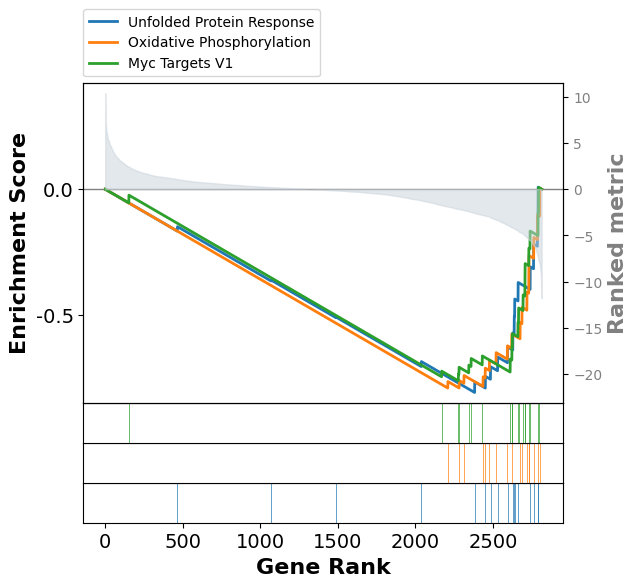

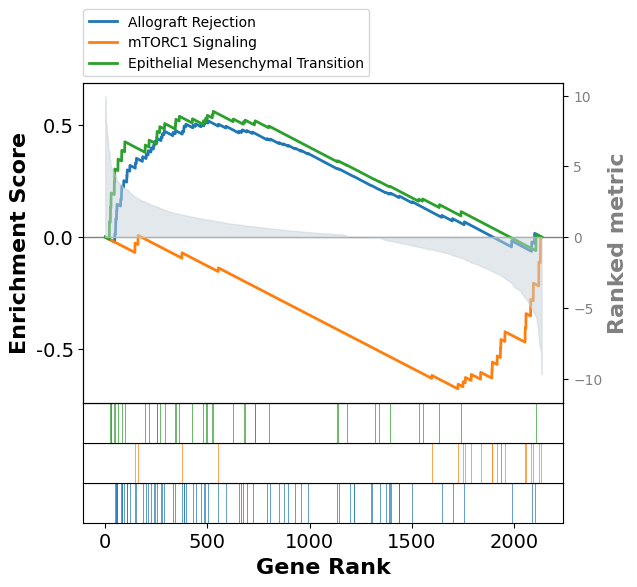

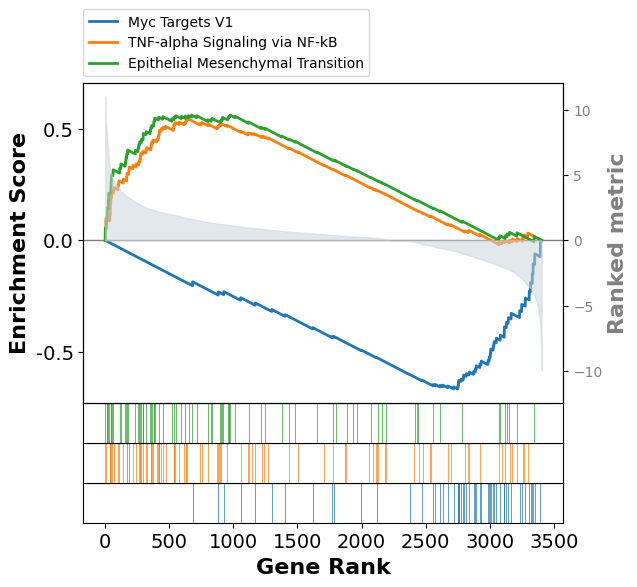

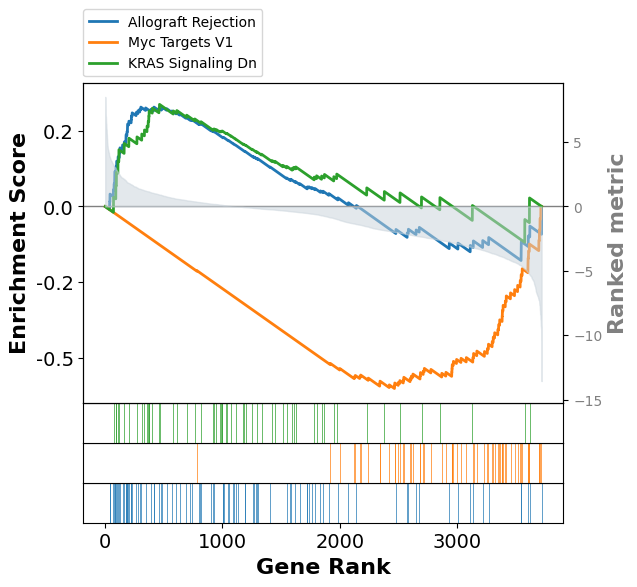

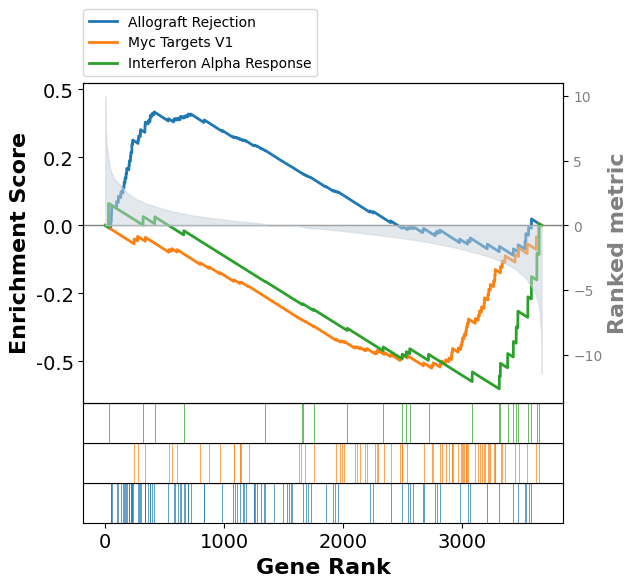

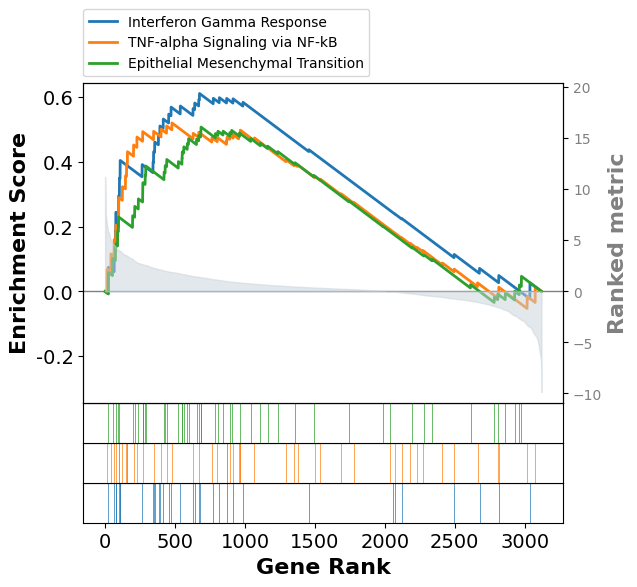

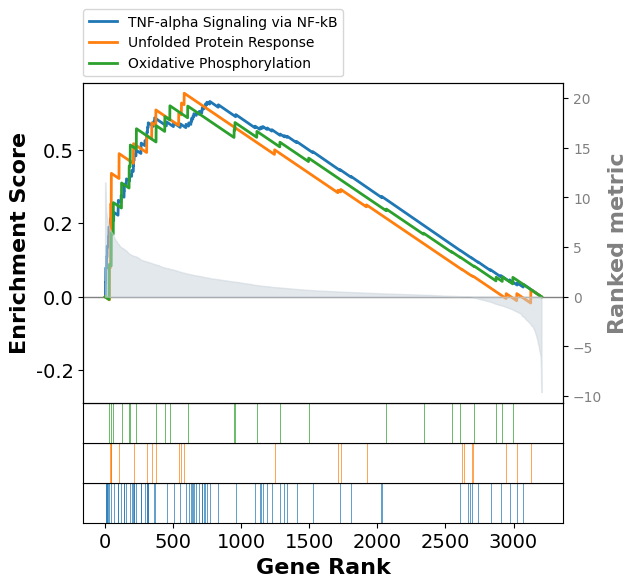

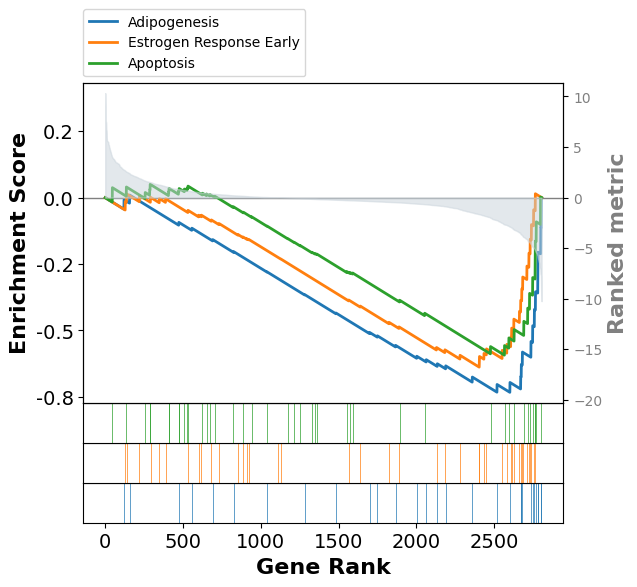

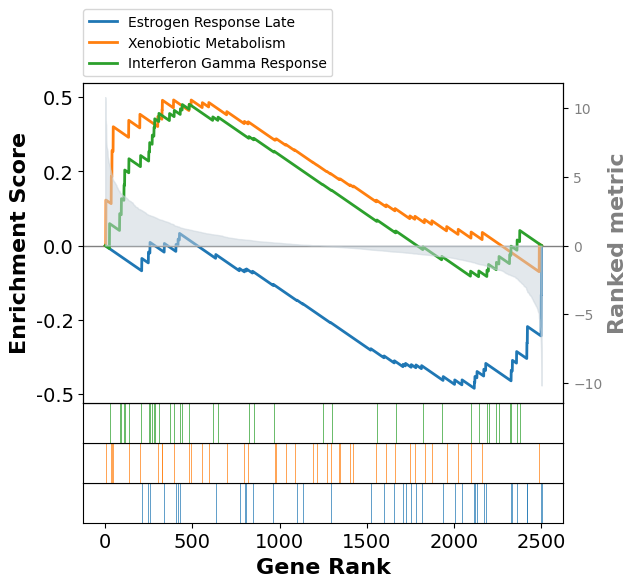

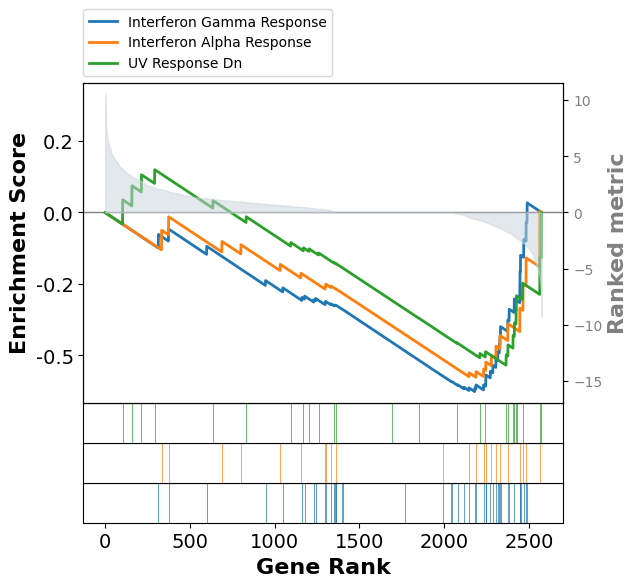

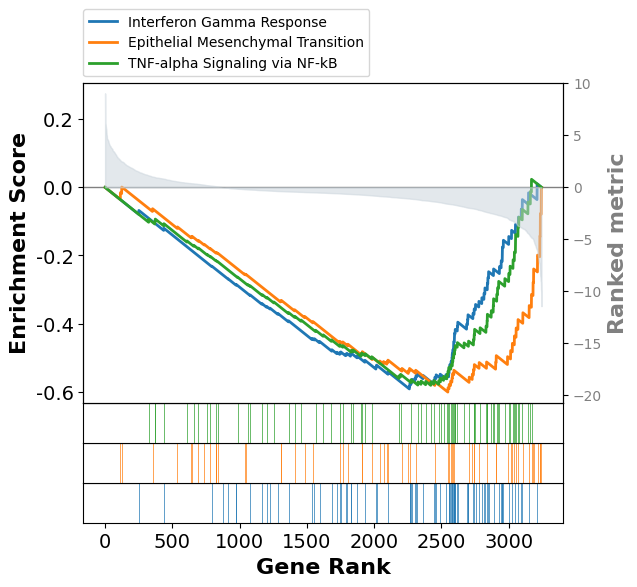

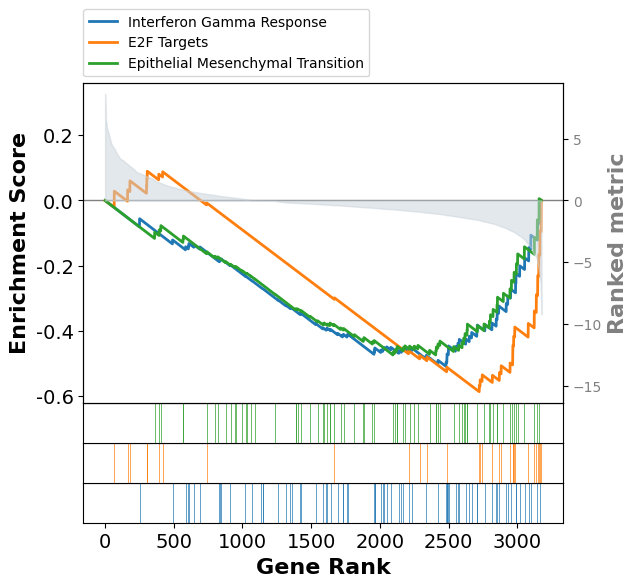

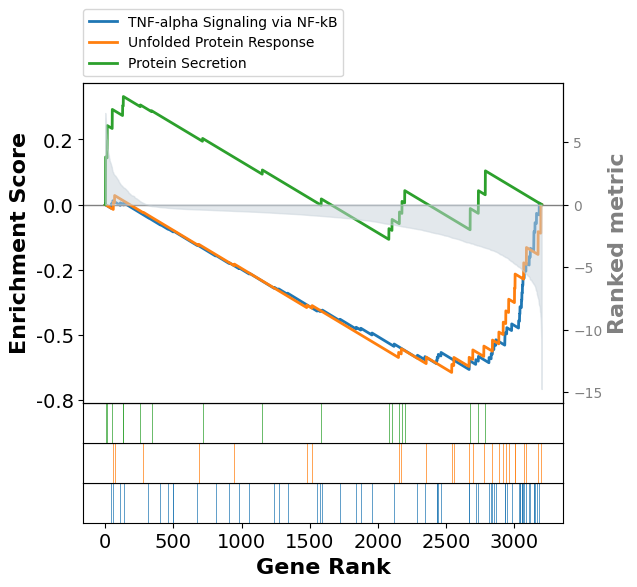

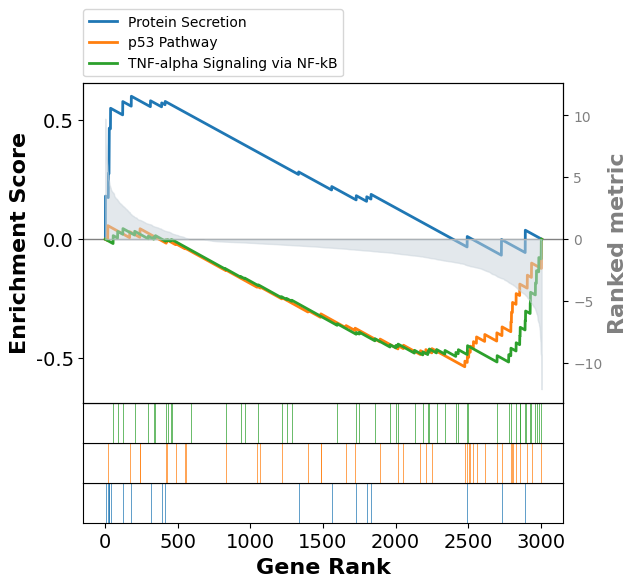

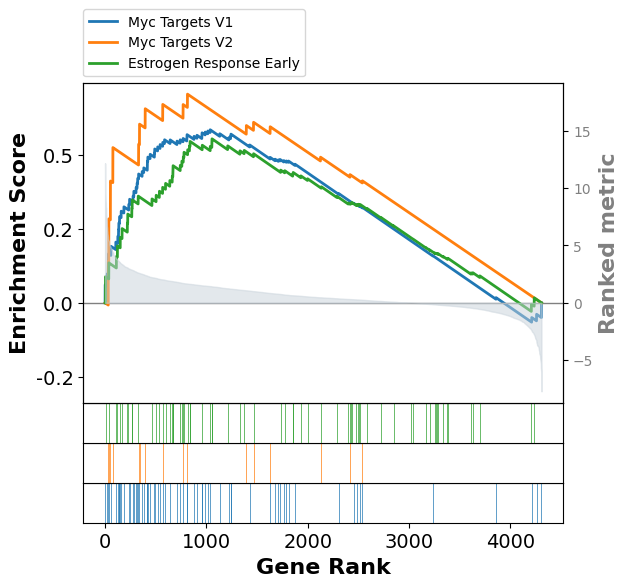

In [39]:
from itertools import combinations
from collections import Counter


PairedFGSEA_Tiles = dict()
for Tile_1, Tile_2 in combinations(set(adata_tumor_inTILEs["Clone"].to_list()), 2):
    print(Tile_1, Tile_2)
    pre_res = go_fgsea(adata, Tile_1, Tile_2, cluster_key="Clone" ,gene_set="MSigDB_Hallmark_2020" , show_plot=False)
    PairedFGSEA_Tiles[f"{Tile_1}_{Tile_2}"] = pre_res
    PairedFGSEA_Tiles[f"{Tile_2}_{Tile_1}"] = pre_res
PairedFGSEA_Tiles